In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
import pandas as pd

**Importing the Tweet Emotion dataset**

In [15]:

train = pd.read_csv('/content/dataset/train.txt', sep=';', names=['text', 'emotion'])
test = pd.read_csv('/content/dataset/test.txt', sep=';', names=['text', 'emotion'])
val = pd.read_csv('/content/dataset/val.txt', sep=';', names=['text', 'emotion'])


In [16]:
train.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [22]:
def get_tweet(train):
    tweets = train['text'].tolist()
    labels = train['emotion'].tolist()
    return tweets, labels

In [23]:
tweets, labels = get_tweet(train)

In [24]:
for i in range(5):
  print(f"('{tweets[i]}', '{labels[i]}')")

('i didnt feel humiliated', 'sadness')
('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'sadness')
('im grabbing a minute to post i feel greedy wrong', 'anger')
('i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'love')
('i am feeling grouchy', 'anger')


**Tokenizer**

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [26]:
tokenizer=Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [27]:
print(tweets[1])
tokenizer.texts_to_sequences([tweets[1]])

i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake


[[2,
  40,
  101,
  60,
  8,
  15,
  494,
  5,
  15,
  3496,
  553,
  32,
  60,
  61,
  128,
  148,
  76,
  1480,
  4,
  22,
  1255]]

**Padding and Truncating Sequences**

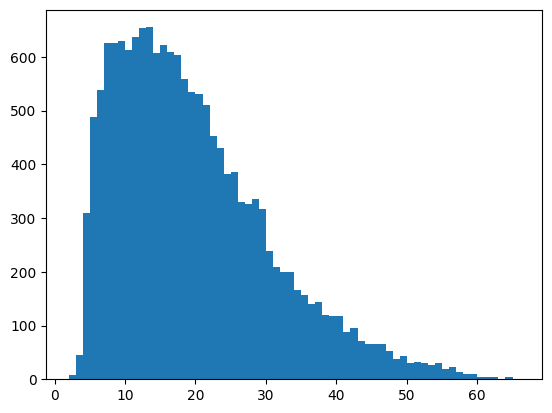

In [28]:
lengths=[len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [29]:
maxlen=50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [31]:
def get_sequences(tokenizer, tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [32]:
padded_train_seq=get_sequences(tokenizer, tweets)

In [33]:
padded_train_seq[1]

array([   2,   40,  101,   60,    8,   15,  494,    5,   15, 3496,  553,
         32,   60,   61,  128,  148,   76, 1480,    4,   22, 1255,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

**Preparing the Labels**

In [35]:
classes=set(labels)
print(classes)


{'sadness', 'love', 'surprise', 'anger', 'joy', 'fear'}


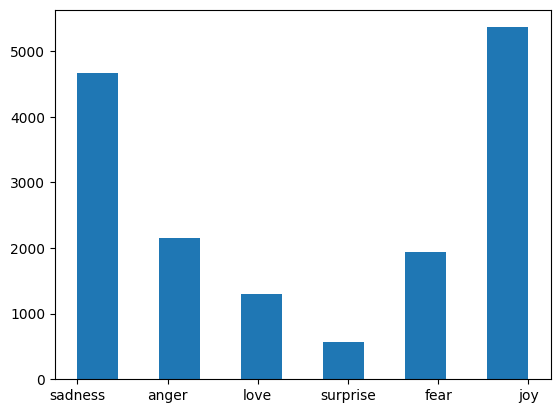

In [36]:
plt.hist(labels, bins=11)
plt.show()

In [37]:
class_to_index=dict((c,i) for i,c in enumerate(classes))
class_to_index


{'sadness': 0, 'love': 1, 'surprise': 2, 'anger': 3, 'joy': 4, 'fear': 5}

In [39]:
index_to_class=dict((v,k) for k,v in class_to_index.items())
index_to_class

{0: 'sadness', 1: 'love', 2: 'surprise', 3: 'anger', 4: 'joy', 5: 'fear'}

In [42]:
names_to_indexes=lambda labels: np.array([class_to_index.get(x) for x in labels])

In [44]:
train_labels=names_to_indexes(labels)

In [45]:
train_labels[0:5]

array([0, 0, 3, 1, 3])

**Model Building**

In [46]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=maxlen),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20)),
  tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


**Training the model**

In [49]:
val_tweets, val_labels = get_tweet(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_indexes(val_labels)

In [51]:
val_tweets[0], val_labels[0]


('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [52]:
hypothesis = model.fit(
    x=padded_train_seq,
    y=train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 41s 65ms/step - loss: 1.4118 - accuracy: 0.4441 - val_loss: 1.1211 - val_accuracy: 0.5870
Epoch 2/20
500/500 [==============================] - 31s 62ms/step - loss: 0.7364 - accuracy: 0.7433 - val_loss: 0.4998 - val_accuracy: 0.8570
Epoch 3/20
500/500 [==============================] - 30s 61ms/step - loss: 0.2696 - accuracy: 0.9164 - val_loss: 0.3823 - val_accuracy: 0.8810
Epoch 4/20
500/500 [==============================] - 32s 64ms/step - loss: 0.1506 - accuracy: 0.9544 - val_loss: 0.3660 - val_accuracy: 0.8905
Epoch 5/20
500/500 [==============================] - 37s 74ms/step - loss: 0.0999 - accuracy: 0.9694 - val_loss: 0.3840 - val_accuracy: 0.8855
Epoch 6/20
500/500 [==============================] - 31s 62ms/step - loss: 0.0752 - accuracy: 0.9765 - val_loss: 0.3981 - val_accuracy: 0.8860


**Training history**

In [53]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

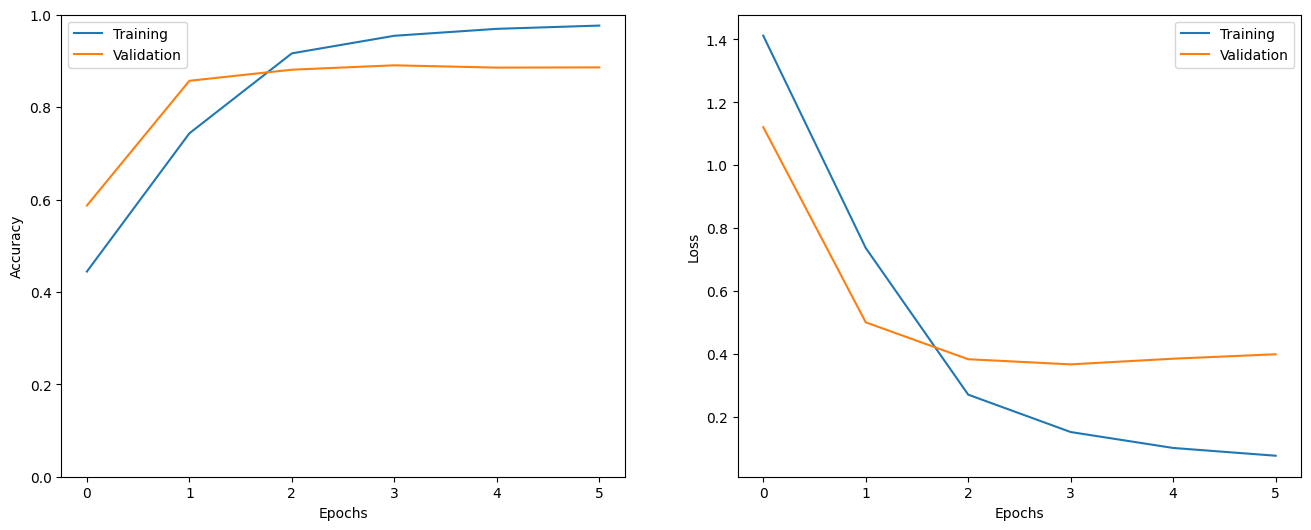

In [54]:
show_history(hypothesis)

**Evaluating the model**

In [56]:
test_tweets, test_labels = get_tweet(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_indexes(test_labels)

In [58]:
evaluation= model.evaluate(x=test_sequences, y=test_labels)

63/63 [==============================] - 2s 25ms/step - loss: 0.4510 - accuracy: 0.8700


In [59]:
predictions = model.predict(test_sequences)
predicted_classes = np.argmax(predictions, axis=1)

63/63 [==============================] - 4s 29ms/step


In [61]:
def confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

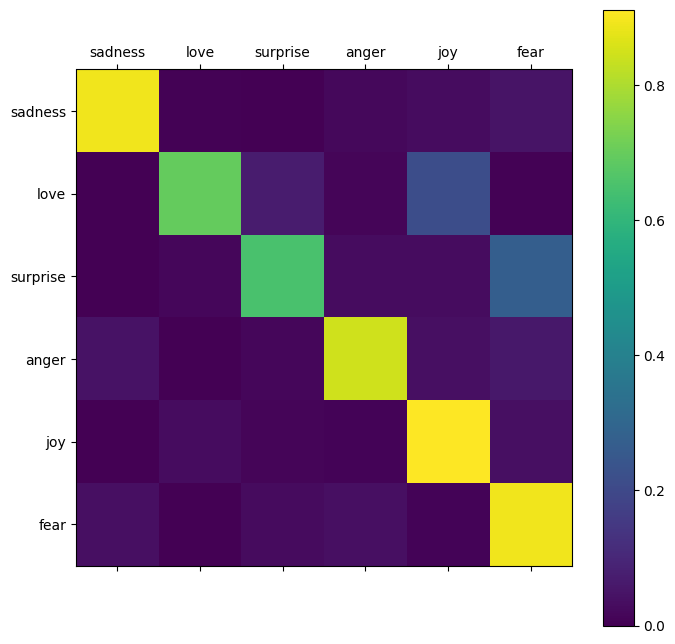

In [62]:
confusion_matrix(test_labels, predicted_classes, list(classes))